In [1]:
import os
import random
import itertools
import re


# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from tqdm import tqdm
import warnings

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# draw KM line
from lifelines import KaplanMeierFitter, CoxPHFitter

# config python file
import config
import functions

SEED = config.SEED
INDEX_MICROARRAY = config.INDEX_MICROARRAY
functions.fix_seed(SEED)

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_recurrenced.pkl"
)

/breast_cancer_analytics/notebooks/functions.py:411: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_train: pd.Series(),
/breast_cancer_analytics/notebooks/functions.py:413: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_val: pd.Series(),


# データ読み込み

In [30]:
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

feature_selection_methods = [
    # "variance_threshold",
    "mrmr"
]

scaling_methods = [
    "std",
    # "norm"
]

sampling_methods = ["smote"]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("#####" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            print("=====" * 10)
            print("subgroup: ", subgroup)
            input_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
                subgroup_column,
                preprocess_order,
            )
            input_file_name = subgroup
            print(input_file_path, input_file_name)
            try:
                _, _, list_train_val, list_test = functions.read_preprocessed_df(
                    input_file_path, input_file_name
                )
            except:
                continue
            X_train, y_train = list_train_val[0], list_train_val[1]
            X_test, y_test = list_test[0], list_test[1]

1it [00:00, 165.20it/s]

##################################################
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB
./../data/interim/PREPROCESSED/RECURRENCE/CROSS/CLAUDIN_SUBTYPE/mrmr_std_smote LumB
subgroup:  Her2
./../data/interim/PREPROCESSED/RECURRENCE/CROSS/CLAUDIN_SUBTYPE/mrmr_std_smote Her2
subgroup:  LumA
./../data/interim/PREPROCESSED/RECURRENCE/CROSS/CLAUDIN_SUBTYPE/mrmr_std_smote LumA
subgroup:  claudin-low
./../data/interim/PREPROCESSED/RECURRENCE/CROSS/CLAUDIN_SUBTYPE/mrmr_std_smote claudin-low
pkl file does not exist
subgroup:  Basal
./../data/interim/PREPROCESSED/RECURRENCE/CROSS/CLAUDIN_SUBTYPE/mrmr_std_smote Basal
pkl file does not exist
subgroup:  Normal
./../data/interim/PREPROCESSED/RECURRENCE/CROSS/CLAUDIN_SUBTYPE/mrmr_std_smote Normal
pkl file does not exist
subgroup:  NC
./../data/interim/PREPROCESSED/RECURRENCE/CROSS/CLAUDIN_SUBTYPE/mrmr_std_smote NC
pkl file does not exist


In [135]:
patient_columns = ["RFS_MONTHS", "RFS_STATUS"]
gene_columns = pd.read_pickle(
    "./../data/interim/PREPROCESSED/RECURRENCE/CROSS/CLAUDIN_SUBTYPE/mrmr_std_smote/train_val/X_LumA.pkl"
).columns.to_list()
analytsis_columns = patient_columns + gene_columns

df_patient = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_MB.pkl"
)[patient_columns]
df_patient["RFS_STATUS"] = df_patient["RFS_STATUS"].replace(
    {"1:Recurred": 1, "0:Not Recurred": 0}
)
df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_recurrenced.pkl"
)
df_merged = pd.merge(df_patient, df_recurrenced, left_index=True, right_index=True)

# manual
df_lifeline_analysis = df_merged[df_merged["CLAUDIN_SUBTYPE"] == "LumA"][
    analytsis_columns
]

## Draw KM line

In [152]:
def plot_KM(target_gene: str, is_save: bool = False):
    ax = None
    plt.figure(figsize=(8, 6))
    kmf = KaplanMeierFitter()
    for name, group in df_lifeline_analysis.groupby("target_gene_bin"):
        name = (
            "gene expression is over medium"
            if name == 1
            else "gene expression is under medium"
        )
        kmf.fit(
            durations=group["RFS_MONTHS"],
            event_observed=group["RFS_STATUS"],
            label=name,
        )
        ax = kmf.plot(ax=ax, at_risk_counts=True) if ax else kmf.plot()

    functions.make_dir(config.FIGURES_LIFELINES_RECURRENCE_CROSS_DIR)

    plt.title(target_gene)
    plt.tight_layout()
    ax.set_xlim([0, 5 * 12])
    ax.set_ylim([0, 1])
    plt.savefig(
        "{0}/{1}.png".format(config.FIGURES_LIFELINES_RECURRENCE_CROSS_DIR, target_gene)
    ) if is_save else plt.show()

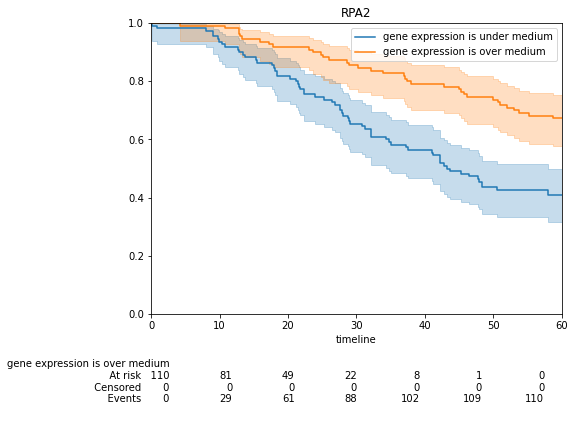

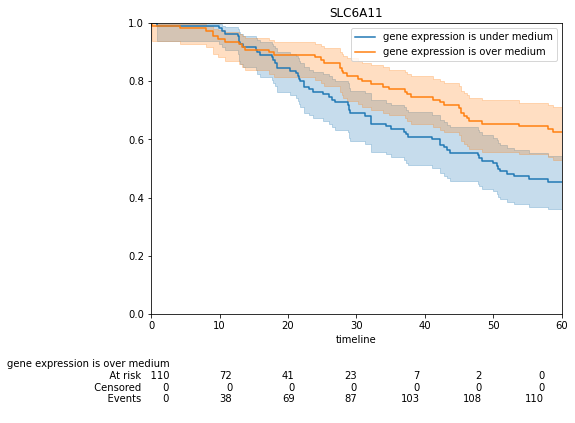

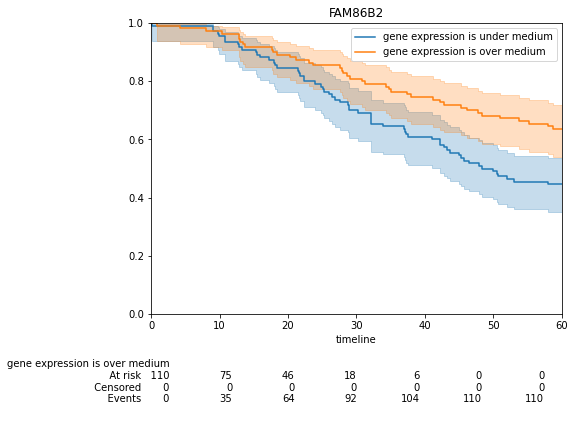

In [153]:
df_genes_threshold = df_lifeline_analysis[gene_columns].apply("median")

analysis_targets = ["SLC6A11", "FAM86B2", "RPA2"]
for gene_column in gene_columns:
    if gene_column in analysis_targets:
        df_lifeline_analysis["target_gene_bin"] = df_lifeline_analysis[
            gene_column
        ].apply(lambda x: 1 if x > df_genes_threshold[gene_column] else -1)
        plot_KM(gene_column, True)

Iteration 1: norm_delta = 0.27623, step_size = 0.9500, log_lik = -970.21419, newton_decrement = 7.50638, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.01091, step_size = 0.9500, log_lik = -962.80321, newton_decrement = 0.01119, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00055, step_size = 0.9500, log_lik = -962.79204, newton_decrement = 0.00003, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -962.79201, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


/root/miniconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 220 total observations, 0 right-censored observations>
             duration col = 'RFS_MONTHS'
                event col = 'RFS_STATUS'
      baseline estimation = breslow
   number of observations = 220
number of events observed = 220
   partial log-likelihood = -962.79
         time fit was run = 2022-10-16 08:11:31 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
SLC6A11    -0.89       0.41       0.43            -1.73            -0.05                 0.18                 0.95
FAM86B2    -0.66       0.52       0.47            -1.58             0.25                 0.21                 1.29
RPA2       -0.57       0.57       0.21            -0.97            -0.16                 0.38                 0.85

            cmp to     z    p   -log2(p)
covariate                               
SLC6A11       0.00 -2.07 0.04       4.70
FAM86B2       0.00 -1.42 0.16       2.68
RPA2          0.00 -2.76 0.01       7.42
---
Concordance = 0.61
Partial AIC = 1931.58
log-likelihood ratio test = 14.84 on 3 df
-log2(p) of ll-ratio test = 9.00

<AxesSubplot:xlabel='log(HR) (95% CI)'>

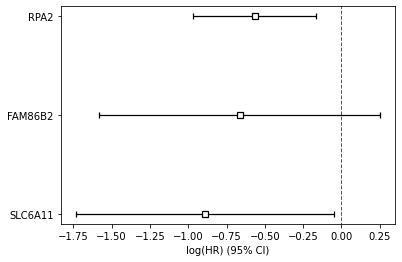

In [150]:
analysis_targets = ["SLC6A11", "FAM86B2", "RPA2"]

cph = CoxPHFitter()
cph.fit(
    df_lifeline_analysis[analysis_targets + patient_columns],
    duration_col="RFS_MONTHS",
    event_col="RFS_STATUS",
    show_progress=True,
)
cph.print_summary()
cph.plot()

In [19]:
df_cross = pd.read_pickle(
    config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_cross.pkl"
)

<AxesSubplot:xlabel='STAT5B', ylabel='Count'>

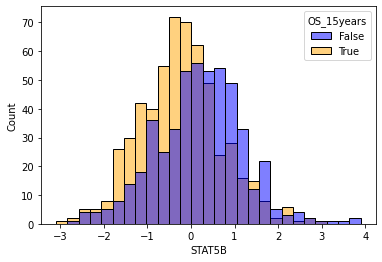

In [20]:
sns.histplot(
    x="STAT5B", data=df_cross, hue="OS_15years", palette={0: "blue", 1: "Orange"}
)